# E-12-(연습)인공지능으로 세상에 없던 패션 만들기

## 데이터셋 분석 및 전처리

* imageio, pillow 라이브러리 설치  
```
$ pip install imageio  
$ pip install Pillow  
```  
* 작업환경 구성  
```  
$ mkdir -p ~/aiffel/dcgan_newimage/fashion/generated_samples  
$ mkdir -p ~/aiffel/dcgan_newimage/fashion/training_checkpoints  
$ mkdir -p ~/aiffel/dcgan_newimage/fashion/training_history  
```

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [2]:
# 데이터셋 불러오기
# fashion_mnist 데이터는 우리가 인터넷에서 따로 다운받을 필요 없이,tf.keras 안에 있는 datasets 꺼내면 됨

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [3]:
# Fashion MNIST 또한 MNIST와 같이 28x28 픽셀의 이미지로, 각 픽셀은 0~255 사이의 정숫값을 가짐

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
# 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눔

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
# 데이터셋의 shape 확인

train_x.shape

# 28*28사이즈 6만 장

(60000, 28, 28)

In [6]:
# 딥러닝에서 이미지를 다루려면 채널 수에 대한 차원이 필요
# 컬러 이미지의 경우 R, G, B 세 개의 채널이 있고, Gray Scale(흑백)의 경우 1개의 채널만 존재
# Fashion MNIST 데이터는 흑백 이미지이므로, 채널 값은 1
# 데이터셋의 shape 마지막에 1을 추가

train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

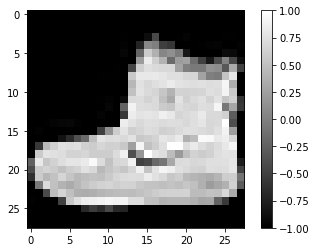

In [7]:
# 첫 번째 데이터를 꺼내서 어떻게 생겼는지 확인

plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar() # 오른쪽에 각 픽셀의 값과 그에 따른 색 확인
               # 픽셀에는 우리가 정규화 해준 대로 -1 ~ 1 사이의 값을 가지고, -1이 가장 어두운 검은색, 1이 가장 밝은 흰색
plt.show()

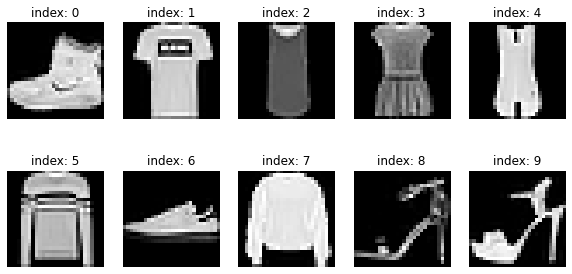

In [8]:
# for문을 이용하여 열 개 정도 한 번에 띄워보기

plt.figure(figsize=(10, 5)) # 이미지의 전체 프레임의 크기

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}') # 이미지에 제목으로 라벨값 넣어줌
    plt.axis('off') # 불필요한 축 제거
plt.show()

여러 개의 이미지를 한 번에 띄우고 싶을 때에는 plt.subplot(row, col, index)의 형태로 볼 수 있습니다.  
10개의 이미지를 2x5의 배열 형태로 보고 싶은 경우, plt.subplot(2, 5, index)로 작성하면 되는 거죠. index는 1부터 10까지 순서대로 바뀌어야 하니 for문에서 사용하는 i에 1을 i+1을 넣어주면 됩니다. (i는 range(10)으로 꺼냈으니 0~9의 숫자로 반복되죠) 

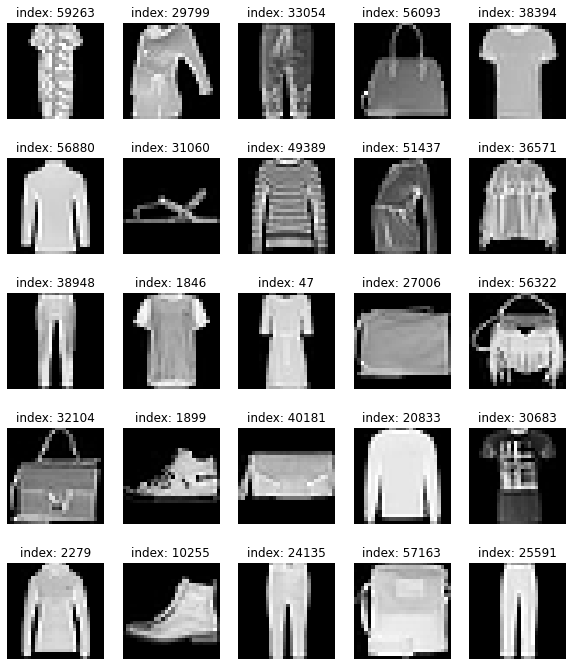

In [9]:
# for 문을 활용해서 이미지 25개를 5x5 의 배열로 띄워보기
# 단, 모든 이미지는 train_images에서 랜덤으로 추출 (힌트 : numpy에서 랜덤으로 정수를 추출해주는 함수를 찾아보세요!)

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

# 데이터 전처리 끝!!

## 학습시킬 데이터셋 준비시키기  
* 텐서플로우의 Dataset을 이용해 준비  
* 이를 이용하면 우리가 매번 섞어서 모델에 넣어주지 않아도 됨

In [10]:
# buffer size : 전체 데이터를 섞기 위해 60,000으로 설정
# batch size : 모델이 한 번에 학습할 데이터의 양

BUFFER_SIZE = 60000
BATCH_SIZE = 256

* 미니배치 학습 : 너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면
# 리스트, 넘파이, 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있습니다.
# 위 코드는 train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 합니다.
# 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋습니다.

## 생성원 generator 구현하기

In [12]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [14]:
# 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 만들기

noise = tf.random.normal([1, 100])

In [15]:
# 지금은 학습하는 중이 아니니 training=False를 설정해 주어야 합니다!
# Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에
# training=False을 주어야 올바른 결과를 얻을 수 있습니다.

generated_image = generator(noise, training=False)
generated_image.shape

# 첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (28, 28, 1) 사이즈 이미지가 생성되었다는 뜻을 가집니다. 

TensorShape([1, 28, 28, 1])

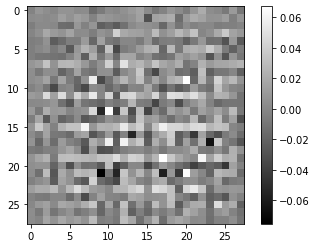

In [16]:
# 이 이미지를 또 시각화해서 봐야겠습니다.
# matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서
# (28, 28) shape의 이미지를 꺼낼 수 있도록 해야 합니다.

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

## 판별자 discriminator 구현하기

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [19]:
# 가짜 이미지 입력해 보기
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00416198]], dtype=float32)>

## 손실함수와 최적화 함수  
### 손실함수(loss function)  
GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용합니다.  
교차 엔트로피는 앞서 분류 모델을 설계할 때 많이 사용했던 손실함수이죠. 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰입니다. 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것입니다.  
  
자, 이쯤에서 다시 생성자와 판별자의 목적이 무엇이었는지 한번 정리해 볼까요? 생성자는 자기가 생성한 Fake Image를 판별자가 진짜라고 판단하도록 속이고 싶어 합니다. 판별자는 생성자가 생성한 가짜 이미지를 가짜로, 진짜 이미지를 진짜로 잘 판별하는 것이 목표입니다.  
  
좋습니다!  
그렇다면 Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같겠죠.  
  
    생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것  
    판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것  
  
결국 생성자든 구분자든, 결국 손실함수에 들어가는 값은 모두 판별자의 판별값이 되겠네요! 이러한 기준을 가지고 생성자, 판별자 각각에 대한 손실함수를 설계해 봅시다.  
  
손실함수에 사용할 교차 엔트로피 함수는 tf.keras.losses 라이브러리 안에 있습니다.  
  
다만, 우리가 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었습니다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있죠.  
  
그런데 tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다 (참고). 따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있습니다.

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

그럼, 이제 cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용합니다.  
  
    fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)  
    real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)  
  
그럼 이제, fake_output과 real_output을 각각 1 또는 0에 비교를 해야 하는데, 어떻게 비교할 수 있을까요?  
  
바로 tf.ones_like()와 tf.zeros_like() 함수를 활용하면 됩니다.  
이 함수들은 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용합니다.  
어떤 식으로 활용되는지, 한번 실험해 볼까요?

In [21]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

어떤가요? 입력해 준 vector와 형태는 같지만, 그 내용물은 모두 1인 벡터가 만들어졌습니다. 간단히 원하는 영벡터 또는 1로 채워진 벡터를 만들어낼 수 있는 거죠!  
#### generator_loss  
그러면 generator_loss는 다음과 같이 구현할 수 있겠군요.  
  
generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.  
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### discriminator_loss  
반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!  
  
최종 discriminator_loss 값은 이 둘을 더한 값입니다.

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### discriminator accuracy  
한편, 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요합니다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용합니다.  
  
만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까요? 그렇지 않습니다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻입니다. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻입니다.

In [24]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

위 함수 안에 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리하면 다음과 같습니다.  
  
ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,  
  
    (1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별  
        >> tf.Tensor([False, False, True, True])  
    (2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환  
        >> tf.Tensor([0.0, 0.0, 1.0, 1.0])  
    (3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산  
        >> 0.5

### 최적화 함수(optimizer)  
이제 최적화 함수를 설정할 차례입니다. 이번에는 Adam 최적화 기법 을 활용해 보겠습니다.  
  
Adam 함수 또한 tf.keras.optimizers 안에 있습니다.  
중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천합니다.  
  
또한, 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.  
참고 : https://sacko.tistory.com/42

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

또한, 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.  
  
샘플은 한 번에 16장을 생성하도록 하겠습니다.  
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.  
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.

In [26]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 설계

In [27]:
# 하나의 미니배치 당 진행할 train_step 함수 만들기

import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [28]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [29]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

train_step 함수를 하나하나 뜯어보면 다음과 같습니다.  
  
    (1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음  
    (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함  
    (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기  
    (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성  
    (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력  
    (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산  
    (7) accuracy 계산 : fake_output, real_output으로 discriminator가  
    (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산  
    (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신  
    (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴  
  
이러한 일련의 과정을 통해 한 번의 train_step이 끝나게 됩니다.

In [30]:
# 한 단계씩 학습할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 만들기
# 아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인 가능

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [31]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

다음은 정기적으로 모델을 저장하기 위한 checkpoint를 만들어줍니다.  
  
tf.train.Checkpoint를 활용하면 매번 모델을 직접 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있습니다.  
모델이 복잡해지고 학습 속도가 오래 걸릴수록, 모델에 대한 저장 및 버전 관리는 필수적입니다. 아주 오랜 시간동안 학습을 시켰는데 네트워크가 끊긴다거나, 예상치 못한 문제로 인해 모델을 잃어버린다면 그보다 끔찍한 일은 없을 테니까요..!  
  
checkpoint에는 optimizer와 생성자, 구분자를 모두 넣어 저장합니다. 정확히는 생성자와 구분자가 학습한 모델 가중치를 저장하는 것이죠. 게임의 체크포인트처럼 우리의 학습 환경과 학습한 내용을 저장해 둡니다.  
  
checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints 라는 디렉토리를 사용하겠습니다.

In [32]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 학습시키기  
지금까지 한 단계를 학습하는 train_step, 샘플 이미지를 생성하고 저장하기 위한 generate_and_save_images(), 학습 과정을 시각화하는 draw_train_history(), 그리고 모델까지 저장하기 위한 checkpoint까지 모두 준비가 되었으니 이것들을 한 곳에 합치기만 하면 됩니다.  
  
한번 확인해 볼까요!

In [33]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [34]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

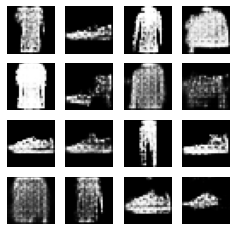

Time for training : 591 sec


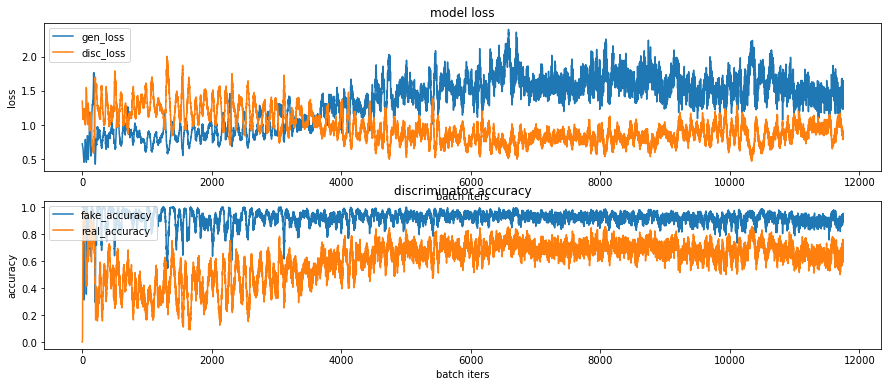

CPU times: user 4min 8s, sys: 10.4 s, total: 4min 19s
Wall time: 9min 52s


In [35]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## 학습과정 시각화

In [36]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 aiffel-dj42 aiffel-dj42 1316478  2월 23 12:25 /home/aiffel-dj42/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


## 프로젝트 : CIFAR-10 이미지 생성하기  
GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.  
  
이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.  
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.  
  
* 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.  
* 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.  
* 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

### 0. 작업환경 구성하기  
```
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples  
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints  
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history  
```

### 1. 데이터셋 구성하기  
CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [37]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

* 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.  
* 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.  
* tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

### 2. 생성자 모델 구현하기  
* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.  
* noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.  
* 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

### 3. 판별자 모델 구현하기  
* (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.  
* 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

### 4. 손실함수와 최적화 함수 구현하기  
* 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.  
* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.  
* 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

### 5. 훈련과정 상세 기능 구현하기  
* 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.  
* 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.  
* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.  
* training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

### 6. 학습 과정 진행하기  
* 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.  
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.  
* 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.  
  
(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.  
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.  
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

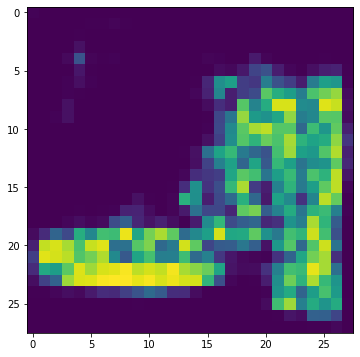

In [38]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다.  
```
%%time
train(train_dataset, EPOCHS, save_every)
```

### 7. (optional) GAN 훈련 과정 개선하기  
* STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.  
* 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.  
  
(참고) 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것입니다.  
* How to Train a GAN? Tips and tricks to make GANs work : https://github.com/soumith/ganhacks  
* 10 Lessons I Learned Training GANs for one Year : https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628  
* Tips for Training Stable Generative Adversarial Networks : https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/  
* Improved Techniques for Training GANs(paper) : https://papers.nips.cc/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf

### 프로젝트 제출 시, gif 파일도 같이 제출